<a href="https://colab.research.google.com/github/Hamdankim/vegetable-cleanliness-api/blob/main/PCVK_Kelompok3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vegetable Cleanliness Detection

##Preparation

In [ ]:
# 1. Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

DRIVE_PROJECT_DIR = '/content/drive/MyDrive/vegetable-cleanliness-api'
DATA_DIR_AUG = f'{DRIVE_PROJECT_DIR}/data/augmented'
DATA_DIR_RAW = f'{DRIVE_PROJECT_DIR}/data/raw'
MODEL_PATH = f'{DRIVE_PROJECT_DIR}/models/svm_model.pkl'

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

Mounted at /content/drive


In [ ]:
%%bash
pip install opencv-python-headless scikit-image scikit-learn joblib

In [ ]:
# 2. Install deps

import os
import time
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import joblib
import random

## Preprocesssing

In [ ]:
def preprocess_and_augment(img, filename, target_dir,
                           size=(256,256), blur='gaussian', ksize=3):

    os.makedirs(target_dir, exist_ok=True)

    # === 1. BLUR ===
    match blur:
        case 'gaussian':
            img = cv2.GaussianBlur(img, (ksize, ksize), 0)
        case 'median':
            img = cv2.medianBlur(img, ksize)
        case 'mean':
            img = cv2.blur(img, (ksize, ksize))

    # === 2. RESIZE ===
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)

    # === 3. NORMALIZE (0–1) ===
    img = img.astype(np.float32) / 255.0

    # === SAVE ORIGINAL PREPROCESS ===
    cv2.imwrite(os.path.join(target_dir, f"{filename}_orig.png"),
                (img * 255).astype(np.uint8))

    # === AUGMENTATION ===
    # rot90
    aug = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_rot90.png"), (aug*255).astype(np.uint8))

    # rot180
    aug = cv2.rotate(img, cv2.ROTATE_180)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_rot180.png"), (aug*255).astype(np.uint8))

    # rot270
    aug = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_rot270.png"), (aug*255).astype(np.uint8))

    # flip horizontal
    aug = cv2.flip(img, 1)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_flipH.png"), (aug*255).astype(np.uint8))

    # flip vertical
    aug = cv2.flip(img, 0)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_flipV.png"), (aug*255).astype(np.uint8))

    # brightness up
    aug = np.clip(img + 0.12, 0, 1)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_brightUp.png"), (aug*255).astype(np.uint8))

    # brightness down
    aug = np.clip(img - 0.12, 0, 1)
    cv2.imwrite(os.path.join(target_dir, f"{filename}_brightDown.png"), (aug*255).astype(np.uint8))

    # === return citra hasil PREPROCESS (0–1) ===
    return img


## Load Preprocessing

In [ ]:
# === LOOPING SEMUA FILE DALAM RAW DIRECTORY ===
supported_ext = (".jpg", ".jpeg", ".png", ".bmp", ".tif")

for root, dirs, files in os.walk(DATA_DIR_RAW):
    for fname in files:
        if fname.lower().endswith(supported_ext):
            path = os.path.join(root, fname)
            img = cv2.imread(path)
            if img is None:
                print("Gagal membaca:", fname)
                continue

            # ambil nama class dari nama folder (bersih/kotor)
            class_name = os.path.basename(root)

            # directori output sesuai class
            TARGET_DIR = os.path.join(DATA_DIR_AUG, class_name)

            filename = os.path.splitext(fname)[0]
            preprocess_and_augment(img, filename, TARGET_DIR)

print("🔥 SELESAI! Semua hasil preprocess & augment disimpan sesuai folder kelas.")

🔥 SELESAI! Semua hasil preprocess & augment disimpan sesuai folder kelas.


## Tes Hasil Preprocessing

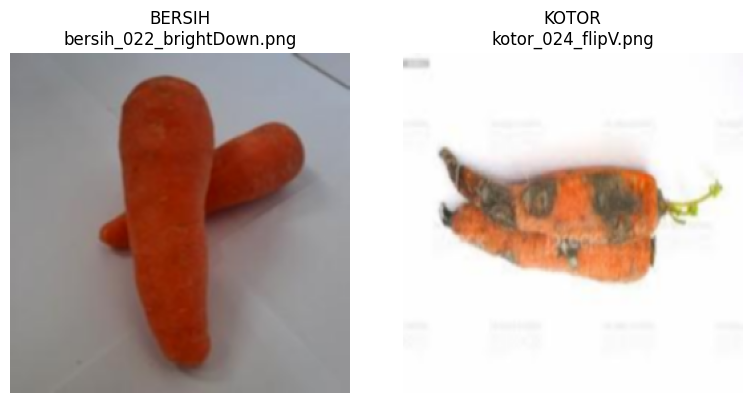

In [ ]:
BERSIH_DIR = os.path.join(DATA_DIR_AUG, 'bersih')
KOTOR_DIR = os.path.join(DATA_DIR_AUG, 'kotor')

def get_random_image(folder):
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    if not files:
        return None, None
    fname = random.choice(files)
    path = os.path.join(folder, fname)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, fname

# ambil gambar random bersih & kotor
img_bersih, name_bersih = get_random_image(BERSIH_DIR)
img_kotor,  name_kotor  = get_random_image(KOTOR_DIR)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img_bersih)
plt.title(f"BERSIH\n{name_bersih}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_kotor)
plt.title(f"KOTOR\n{name_kotor}")
plt.axis("off")

plt.tight_layout()
plt.show()


## Segmentasi (Grab-cut)

In [ ]:
def grabcut_segment(img):
    mask = np.zeros(img.shape[:2], np.uint8)

    # model background & foreground (dibutuhkan GrabCut)
    bgModel = np.zeros((1,65), np.float64)
    fgModel = np.zeros((1,65), np.float64)

    # Tentukan ROI (bisa otomatis pakai bounding box seluruh gambar)
    height, width = img.shape[:2]
    rect = (10, 10, width-20, height-20)

    # GrabCut
    cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)

    # Buat mask final: foreground (1/3) → 1, background (0/2) → 0
    final_mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')

    segmented = img * final_mask[:, :, np.newaxis]
    return segmented, final_mask


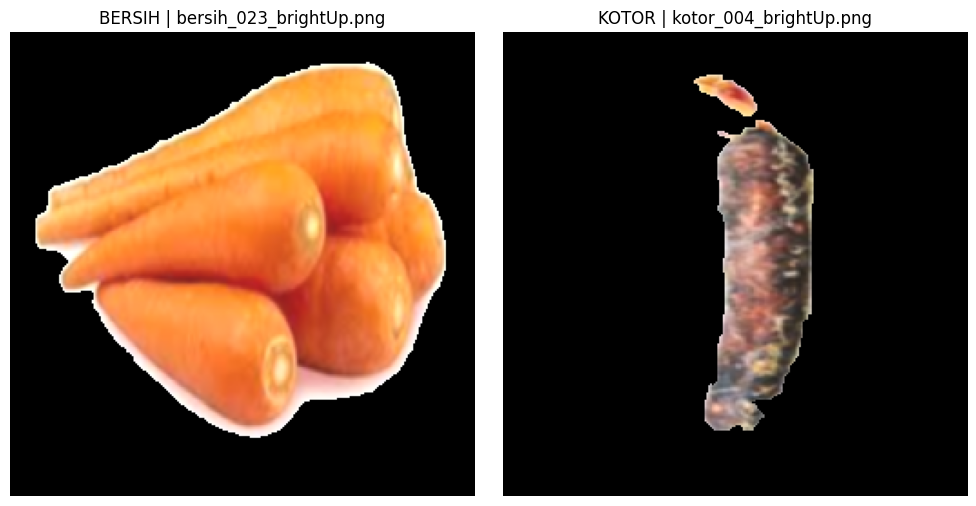

In [ ]:
def show_random_grabcut_aug():
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    idx = 0

    for cname in ['bersih', 'kotor']:
        folder = os.path.join(DATA_DIR_AUG, cname)

        if not os.path.isdir(folder):
            print("Folder tidak ditemukan:", folder)
            continue

        # list file gambar
        files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
        if len(files) == 0:
            print("Tidak ada gambar di:", folder)
            continue

        # ambil satu random
        fname = random.choice(files)
        path = os.path.join(folder, fname)

        # read image augmented
        img = cv2.imread(path)
        if img is None:
            print("Gagal load:", fname)
            continue

        # GRABCUT (langsung tanpa preprocessing)
        seg, mask = grabcut_segment(img)

        # convert BGR to RGB
        seg_rgb = cv2.cvtColor(seg, cv2.COLOR_BGR2RGB)

        ax[idx].imshow(seg_rgb)
        ax[idx].set_title(f"{cname.upper()} | {fname}")
        ax[idx].axis('off')
        idx += 1

    plt.tight_layout()
    plt.show()


show_random_grabcut_aug()


## Ekstraksi Fitur Warna

In [30]:
def extract_color_features(img, color_mode: str = "strict"):
    if color_mode == "strict":
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)
    else:
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    H, S, V = cv2.split(hsv)

    features = {
        "H_mean": np.mean(H), "H_std": np.std(H),
        "S_mean": np.mean(S), "S_std": np.std(S),
        "V_mean": np.mean(V), "V_std": np.std(V)
    }
    return features


## Ekstraksi Fitur GLCM

In [ ]:
def extract_glcm(img_gray):
    glcm = graycomatrix(img_gray, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)

    features = {
        "contrast": graycoprops(glcm, 'contrast').mean(),
        "dissimilarity": graycoprops(glcm, 'dissimilarity').mean(),
        "homogeneity": graycoprops(glcm, 'homogeneity').mean(),
        "energy": graycoprops(glcm, 'energy').mean(),
        "ASM": graycoprops(glcm, 'ASM').mean(),
        "correlation": graycoprops(glcm, 'correlation').mean(),
    }

    return features


## Load Segmentasi dan Ekstraksi Fitur

In [31]:
classes = {'bersih': 0, 'kotor': 1}
X = []   # fitur
y = []   # label

t0 = time.time()

for cname, label in classes.items():

    folder = os.path.join(DATA_DIR_AUG, cname)
    if not os.path.isdir(folder):
        print('Missing folder:', folder)
        continue

    # hanya baca file hasil preprocessing/augmentasi
    files = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
    print(f'{cname}: {len(files)} file')

    for i, f in enumerate(files, start=1):

        path = os.path.join(folder, f)
        img = cv2.imread(path)

        if img is None:
            print("!! gagal load:", f)
            continue

        # =====================
        # 1. SEGMENTASI GRABCUT
        # =====================
        seg, mask = grabcut_segment(img)

        # =====================
        # 2. FITUR WARNA (HSV)
        # =====================
        feat_color = extract_color_features(seg)

        # =====================
        # 3. FITUR GLCM
        # =====================
        gray = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
        feat_glcm = extract_glcm(gray)

        # Gabungkan fitur warna + tekstur
        feats = list(feat_color.values()) + list(feat_glcm.values())

        X.append(feats)
        y.append(label)

        if i % 20 == 0:
            print(f'  progress {cname}: {i}/{len(files)}')

# =====================
# KONVERSI KE ARRAY
# =====================
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.int32)

print('\n====================')
print('Total sampel:', len(X))
print('Waktu eksekusi:', round(time.time() - t0, 2), 'detik')
print('Bersih:', (y == 0).sum(), '| Kotor:', (y == 1).sum())
print('Shape fitur:', X.shape)

assert len(set(y)) == 2, 'Dataset harus terdiri dari 2 kelas'


bersih: 200 file
  progress bersih: 20/200
  progress bersih: 40/200
  progress bersih: 60/200
  progress bersih: 80/200
  progress bersih: 100/200
  progress bersih: 120/200
  progress bersih: 140/200
  progress bersih: 160/200
  progress bersih: 180/200
  progress bersih: 200/200
kotor: 200 file
  progress kotor: 20/200
  progress kotor: 40/200
  progress kotor: 60/200
  progress kotor: 80/200
  progress kotor: 100/200
  progress kotor: 120/200
  progress kotor: 140/200
  progress kotor: 160/200
  progress kotor: 180/200
  progress kotor: 200/200

Total sampel: 400
Waktu eksekusi: 288.08 detik
Bersih: 200 | Kotor: 200
Shape fitur: (400, 12)


## Klasifikasi (SVM)

In [32]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# svm
clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale', probability=True))
])

clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print("Akurasi:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred, target_names=['bersih','kotor']))
print(confusion_matrix(y_test, pred))


Akurasi: 1.0
              precision    recall  f1-score   support

      bersih       1.00      1.00      1.00        40
       kotor       1.00      1.00      1.00        40

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80

[[40  0]
 [ 0 40]]


## Simpan Model

In [33]:
joblib.dump(clf, MODEL_PATH)
print('Saved:', MODEL_PATH)

Saved: /content/drive/MyDrive/vegetable-cleanliness-api/models/svm_model.pkl


## Demo Prediksi Satu Gambar

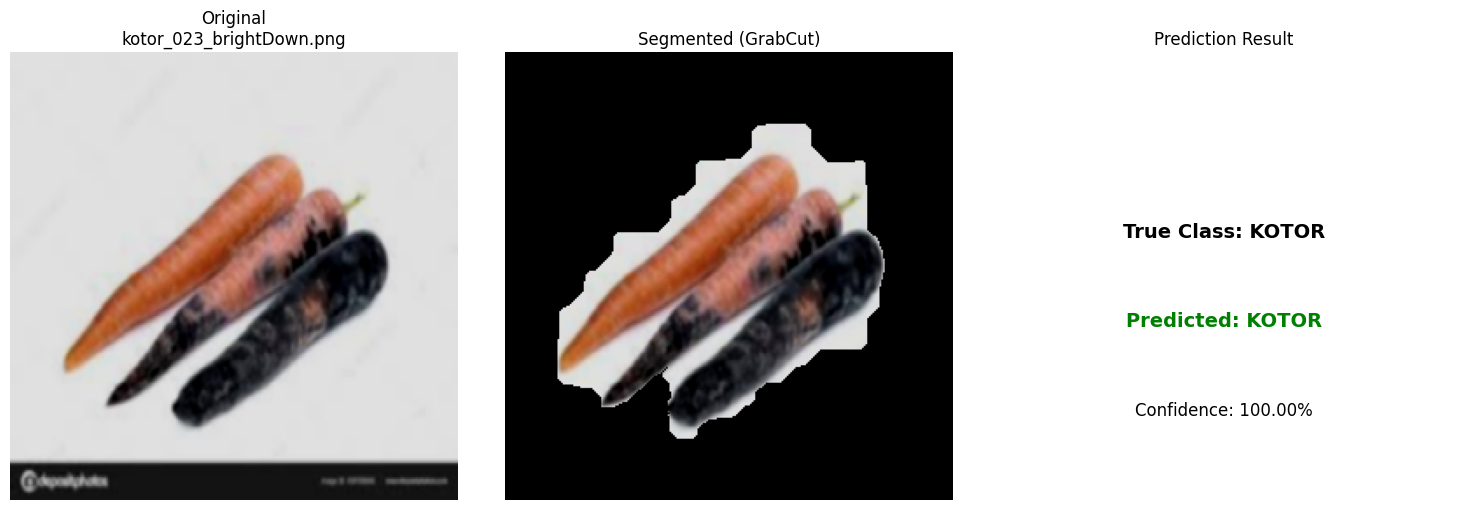


=== HASIL PREDIKSI ===
File: kotor_023_brightDown.png
True Label: KOTOR
Predicted: KOTOR
Status: ✓ BENAR

=== PROBABILITAS ===
Bersih: 0.00%
Kotor: 100.00%


In [34]:
# Demo Prediksi Satu Gambar Random dari Data Test
import random

# Ambil index random dari X_test
random_idx = random.randint(0, len(X_test) - 1)

# Ambil fitur dan label yang sesuai
test_features = X_test[random_idx].reshape(1, -1)
true_label = y_test[random_idx]
true_class = 'bersih' if true_label == 0 else 'kotor'

# Cari gambar yang sesuai dengan index tersebut (untuk visualisasi)
# Karena kita sudah punya fitur, kita ambil gambar random untuk demo
folder = os.path.join(DATA_DIR_AUG, true_class)
files = [f for f in os.listdir(folder) if f.lower().endswith('.png')]
test_fname = random.choice(files)
test_img = cv2.imread(os.path.join(folder, test_fname))

# === PREDIKSI ===
pred_label = clf.predict(test_features)[0]
pred_proba = clf.predict_proba(test_features)[0]

pred_class = 'bersih' if pred_label == 0 else 'kotor'
confidence = pred_proba[pred_label] * 100

# === PIPELINE UNTUK VISUALISASI ===
seg, mask = grabcut_segment(test_img)

# === VISUALISASI ===
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gambar asli
axes[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
axes[0].set_title(f'Original\n{test_fname}')
axes[0].axis('off')

# Hasil segmentasi
axes[1].imshow(cv2.cvtColor(seg, cv2.COLOR_BGR2RGB))
axes[1].set_title('Segmented (GrabCut)')
axes[1].axis('off')

# Hasil prediksi
result_color = 'green' if pred_class == true_class else 'red'
axes[2].text(0.5, 0.6, f'True Class: {true_class.upper()}',
             ha='center', va='center', fontsize=14, weight='bold')
axes[2].text(0.5, 0.4, f'Predicted: {pred_class.upper()}',
             ha='center', va='center', fontsize=14,
             color=result_color, weight='bold')
axes[2].text(0.5, 0.2, f'Confidence: {confidence:.2f}%',
             ha='center', va='center', fontsize=12)
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)
axes[2].axis('off')
axes[2].set_title('Prediction Result')

plt.tight_layout()
plt.show()

# === DETAIL PREDIKSI ===
print('\n=== HASIL PREDIKSI ===')
print(f'File: {test_fname}')
print(f'True Label: {true_class.upper()}')
print(f'Predicted: {pred_class.upper()}')
print(f'Status: {"✓ BENAR" if pred_class == true_class else "✗ SALAH"}')
print('\n=== PROBABILITAS ===')
print(f'Bersih: {pred_proba[0]*100:.2f}%')
print(f'Kotor: {pred_proba[1]*100:.2f}%')